In [1]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_kddcup99
from functions import *
import pickle
import os
import seaborn as sns

In [5]:
! ssh slave2
! rm -r /usr/local/spark/work/*

Welcome to Ubuntu 22.04.4 LTS (GNU/Linux 5.15.0-113-generic x86_64)

 * Documentation:  https://help.ubuntu.com
 * Management:     https://landscape.canonical.com
 * Support:        https://ubuntu.com/pro

  System information as of Sat Jul  6 14:08:37 UTC 2024

  System load:  0.0                Processes:             120
  Usage of /:   17.2% of 24.05GB   Users logged in:       1
  Memory usage: 14%                IPv4 address for ens3: 10.67.22.42
  Swap usage:   0%

 * Strictly confined Kubernetes makes edge and IoT secure. Learn how MicroK8s
   just raised the bar for easy, resilient and secure K8s cluster deployment.

   https://ubuntu.com/engage/secure-kubernetes-at-the-edge

Expanded Security Maintenance for Applications is not enabled.

15 updates can be applied immediately.
To see these additional updates run: apt list --upgradable

Enable ESM Apps to receive additional future security updates.
See https://ubuntu.com/esm or run: sudo pro status


Last login: Sat Jul  6 14:07:

In [98]:

###### FUNCTIONS #######
def labelToInt(label):
    """
    Let's define a map from Y (set of strings) into (0,size(Y)) for easier usage
    """
    uniqueLabels=list(np.unique(y))
    return uniqueLabels.index(label)


def deleteBytes(datum):
    x = datum[1]["x"]
    mask = [type(i) != bytes for i in x]
    datum[1]["x"] = np.asarray(x[mask])
    print(x)
    print(mask)
    return datum
    
def localPlusPlusInit(points, k): 
    #print('pointsshape: ', points.shape)
    '''
    Initialization kmeans ++
    points is a numpy array (n,dim)
    '''
    C=points[np.random.choice(points.shape[0])]#sample from array di punti ecc...
    C=C[np.newaxis, :]
    for _ in range(k-1):
        #points is array (n, dim), C is array(g<=k, dim)
        #probs is array (n,1)
        probs=np.min(np.sum((points[:,:,np.newaxis]-C.T[np.newaxis,:,:])**2, axis=1), axis=1).flatten()
        #probs=[min([sum((point-centroid)**2) for centroid in C]) for point in points] #numpyfy this, or numbafy if left base python
        probs=probs/np.sum(probs)
        nextCentroid=points[np.random.choice(points.shape[0], p=probs)][np.newaxis,:]
        #print('LE FORME',C.shape, nextCentroid.shape)
        C=np.vstack((C, nextCentroid))
    return C


def weightedAverage(group):
    """
    Function to compute the weighted average
    """
    weight_column='weights'
    groupby_column='clusterId'
    columns_to_average = group.columns.difference([weight_column, groupby_column])
    weighted_averages = group[columns_to_average].multiply(group[weight_column], axis=0).sum() / group[weight_column].sum()
    return weighted_averages


def localLloyds(points, k, weights=None, n_iterations=100):
    """
    function that does the Local Lloyds algorithm
    """
    df=pd.DataFrame(points)
    if weights is None:
        weights=np.ones(shape=len(points))
    #print('weights', weights)
    df['weights']=weights
    df['clusterId']=np.zeros(shape=len(points))
    C=localPlusPlusInit(points, k)
    #print('localPlusPluisInit: ', C)
    clusterId=np.argmin(np.sum((points[:,:,np.newaxis]-C.T[np.newaxis,:,:])**2, axis=1), axis=1)
    for iteration in range(n_iterations):
        df['clusterId']=clusterId
        C_df=df.groupby('clusterId')\
            .apply(weightedAverage)\
            .reset_index()
        C_array=C_df[C_df.columns.difference(['weights', 'clusterId'])].reset_index(drop=True).to_numpy()
        clusterId=np.argmin(np.sum((points[:,:,np.newaxis]-C_array.T[np.newaxis,:,:])**2, axis=1), axis=1)
        #print(clusterId)
        
    return C_array   


def minmaxRescale(datum, minS, maxS):
    """
    Rescale a datum in [0,1]
    """
    mask = (minS < maxS).astype(bool)
    feature = datum[1]["x"] 
    feature = (feature[mask] - minS[mask])/(maxS[mask] - minS[mask])
    return (datum[0], {"x": feature, "y": datum[1]["y"], "d2":datum[1]["d2"]}) 


def selectCluster(datum, C, updateDistances=True):
    """
    Associates a datum to its centroid and updates the distance if True
    dimC(k, len(datum))
    """
    distances = np.sum((datum[1]["x"] - C)**2, axis=1)
    print('distances: ',distances)
    clusterId = np.argmin(distances)
    if updateDistances is True:
        return (clusterId, {'x':datum[1]['x'], 'y':datum[1]['y'], 'd2':distances[clusterId]})
    else:
        return (clusterId, datum[1])


def updateCentroids(Rdd):
    """
    update centroids as 'centers of mass' of clusters
    """
    C=Rdd.mapValues(lambda xy: (xy['x'], 1))\
              .reduceByKey(lambda a,b : (a[0]+b[0], a[1]+b[1]))\
              .mapValues(lambda a:a[0]/a[1])\
              .values()\
              .collect() 
    C=np.array(C) #check later more carefully if causes some overhead
    return C


def updateDistances(Rdd, C):
    """
    update the Rdd with square distances from centroids, given Rdd with centroids already updated
    """
    def datumUpdate(datum, C):
        d2=np.sum((datum[1]['x']-C[datum[0]])**2)
        #return datum
        return (datum[0], {"x": datum[1]["x"], "y": datum[1]["y"], "d2":d2})
    Rdd=Rdd.map(lambda datum:datumUpdate(datum, C))
    return Rdd


def cost(Rdd):
    """
    calculate global cost of X,C from an Rdd with distances from centroids already updated
    """
    my_cost=Rdd.map(lambda datum : datum[1]['d2'])\
               .reduce(lambda a,b: a+b)
    return my_cost 


def kMeans(Rdd, C_init, maxIterations, logParallelKmeans=None):
    """
    kMeans in parallel (?)
    """
    
    t0 = time()
    
    my_kMeansCosts = []
    tIterations = []
    C=C_init

    for t in range(maxIterations):
        t1 = time()
        RddCached = Rdd.map(lambda datum: selectCluster(datum, C)).persist()
        # Now we compute the new centroids by calculating the averages of points belonging to the same cluster.
        # Need to check that all centroids are assigned to at least one point, otherwise k changes!!! Solutions?!
        C=updateCentroids(RddCached)
        my_cost = cost(RddCached)
        
        my_kMeansCosts.append(my_cost)
        t2 = time()
        
        tIteration = t2 - t1
        tIterations.append(tIteration)
        
        #RddCached.unpersist() bad for time efficiency, not necessary due to Python Garbage collector
        

    tEnd = time()
    tTotal = tEnd - t0
    
    if logParallelKmeans is not None:
        logParallelKmeans["CostsKmeans"] = my_kMeansCosts
        logParallelKmeans["tIterations"] = tIterations
        logParallelKmeans["tTotal"] = tTotal
        
    return C


def naiveInitFromSet(Rdd, k, logNaiveInit=None):
    """
    uniform sampling of k points from Rdd
    """
    t0 = time()
    
    kSubset=Rdd.takeSample(False, k)
    # Replacement is set to False to avoid coinciding centroids BUT no guarantees that in the original dataset all points are distinct!!! Check if causes problems in the algorithm (i.e. need to pre-filter) or it's ok
    C_init=np.array([datum[1]['x'] for datum in kSubset])

    tEnd = time()
    
    if logNaiveInit is not None:
        logNaiveInit["tTotal"] = tEnd - t0
        
    return C_init


def naiveInitFromSpace(k, dim):
    """
    #uniform drawing of k points from euclidean space
    #we assume the Rdd has been mapped into a [0,1]^dim space
    """
    C_init=np.random.uniform(size=(k,dim))
    return C_init


def parallelInit(Rdd, k, l, logParallelInit=None):
    """
    Parallel initialization
    """
    t0 = time()
    
    # initialize C as a point in the dataset
    C=naiveInitFromSet(Rdd, 1) 
    
    # associate each datum to the only centroid (computed before) and computed distances and cost
    Rdd=Rdd.map(lambda datum : (0, datum[1]))
    Rdd=updateDistances(Rdd, C).persist()
    my_cost=cost(Rdd)

    # number of iterations (log(cost))
    n_iterations=int(np.log(my_cost))
    if(n_iterations<1): n_iterations=1

    
    tSamples = []
    tCentroids = []
    CostInits = [my_cost]
    # iterative sampling of the centroids
    for _ in range(n_iterations):

        t1=time()
        # sample C' according to the probability
        C_prime=Rdd.filter(lambda datum : np.random.uniform()<l*datum[1]['d2']/my_cost)\
                   .map(lambda datum : datum[1]['x'])\
                   .collect()
        C_prime=np.array(C_prime)
        t2=time()

        # stack C and C', update distances, centroids, and cost
        if (C_prime.shape[0]>0):
            C=np.vstack((C, C_prime))
            Rdd=Rdd.map(lambda datum: selectCluster(datum, C)).persist()
            my_cost=cost(Rdd)
        t3=time()

        tSample = t2 -t1
        tCentroid = t3 - t2
        tSamples.append(tSample)
        tCentroids.append(tCentroid)
        CostInits.append(my_cost)
       
    #erase centroids sampled more than once 
    C=C.astype(float)
    C=np.unique(C, axis=0)
    Rdd=Rdd.map(lambda datum: selectCluster(datum, C))
    
    #compute weights of centroids (sizes of each cluster) and put them in a list whose index is same centroid index as C
    wx=Rdd.countByKey()
    weights=np.zeros(len(C))
    weights[[list(wx.keys())]]=[list(wx.values())]
    
    #subselection of k centroids from C, using local Lloyds algorithm with k-means++ initialization
    if C.shape[0]<=k:
        C_init=C
    else:
        C_init=localLloyds(C, k, weights=weights, n_iterations=100)

    tEnd = time()
    
    if logParallelInit is not None:
        logParallelInit["tSamples"] = tSamples
        logParallelInit["tCentroids"] = tCentroids
        logParallelInit["CostInit"] = CostInits
        logParallelInit["tTotal"] = tEnd - t0
        
    return C_init

def predictedCentroidsLabeler(C_expected, C_predicted):
    distMatrix=np.sum((C_expected[:,:,np.newaxis]-C_predicted.T[np.newaxis, :,:])**2,axis=1)
    #the labeler i-th entry j, tells that i-th centroid of C_expected is associated to j-th element of C_predicted
    labeler=np.argmin(distMatrix,axis=1)
    #square distance of element of C_expected to nearest point in C_predicted
    distances=np.sqrt(np.array(distMatrix[np.arange(len(distMatrix)),labeler]).astype(float))
    return labeler, distances

def nearestCentroidDistances(C):
    distMatrix=np.sum((C[:,:,np.newaxis]-C.T[np.newaxis, :,:])**2,axis=1)
    distMatrix+=np.diag(np.repeat(np.inf, distMatrix.shape[0]))
    #the labeler i-th entry j, tells that i-th centroid of C_expected is associated to j-th element of C_predicted
    labeler=np.argmin(distMatrix,axis=1)
    #square distance of element of C_expected to nearest point in C_predicted
    distances=np.sqrt(np.array(distMatrix[np.arange(distMatrix.shape[0]),labeler]).astype(float))
    return labeler, distances

# SET UP SPARK

In [4]:
# import the python libraries to create/connect to a Spark Session
from pyspark.sql import SparkSession

# build a SparkSession 
#   connect to the master node on the port where the master node is listening (7077)
#   declare the app name 
#   configure the executor memory to 512 MB
#   either *connect* or *create* a new Spark Context
spark = SparkSession.builder \
    .master("spark://spark-master:7077")\
    .appName("My first spark application")\
    .config("spark.executor.memory", "512m")\
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/05 10:06:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
# create a spark context
sc = spark.sparkContext
sc.setLogLevel("ERROR")

# DESCRIBE THE DATA SET

In [6]:
data = fetch_kddcup99(return_X_y = True, percent10 = True) # default percent10=True


In [7]:
print("The number of samples is ", data[0].shape[0])
print("The dimensionality is ", data[0].shape[1])

The number of samples is  494021
The dimensionality is  41


Classes: 23
Samples total: 4898431
Dimensionality: 41
Features: discrete (int) or continuous (float)

The first containing a 2D array of shape (n_samples, n_features) with each row representing one sample and each column representing the features


The first 4 elements of the data set (letters, what are them)
Duration: The length (in seconds) of the connection.
Protocol Type: The type of protocol used, such as TCP, UDP, or ICMP.
Service: The network service on the destination, such as HTTP, FTP, or SMTP.
Flag: The status flag of the connection, such as SF (successful connection), REJ (connection rejected), etc.

In [8]:
# collect samples and features (target)
x = data[0]
y = data[1] 

In [9]:
# optional shuffling for better exploration of subset of dataset
shuffling=True
x
if shuffling:
    shuffled_indices = np.random.permutation(len(y))
    x=x[shuffled_indices]
    y=y[shuffled_indices]

In [44]:
# cut the data for memory reasons
subLen = 5000
x = x[:subLen,]
y = y[:subLen]

In [11]:
# cycle over num_slices to be run on cloud veneto on a .py

In [12]:
nSlice = None # IMPORTANT PARAMETER FOR NUMBER OF PARTITIONS
Rdd = sc.parallelize([(None, {"x": x[i],"y": y[i], "d2":None}) for i in range(len(y))], numSlices = nSlice)

In [13]:
Rdd.getNumPartitions() # check partitions

2

In the following cells, the attributes of the dataset:

In [45]:
attributes = [
    "duration",
    "protocol_type",
    "service",
    "flag",
    "src_bytes",
    "dst_bytes",
    "land",
    "wrong_fragment",
    "urgent",
    "hot",
    "num_failed_logins",
    "logged_in",
    "num_compromised",
    "root_shell",
    "su_attempted",
    "num_root",
    "num_file_creations",
    "num_shells",
    "num_access_files",
    "num_outbound_cmds",
    "is_host_login",
    "is_guest_login",
    "count",
    "srv_count",
    "serror_rate",
    "srv_serror_rate",
    "rerror_rate",
    "srv_rerror_rate",
    "same_srv_rate",
    "diff_srv_rate",
    "srv_diff_host_rate",
    "dst_host_count",
    "dst_host_srv_count",
    "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate",
    "dst_host_srv_serror_rate",
    "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate"
]

Check the symbolic variables in the dataset to have only useful data

In [15]:
RddX = Rdd.map(lambda datum: datum[1]["x"]).persist()
typeElement = RddX.map(lambda x: [set([type(x[i])]) for i in range(len(x))])\
                  .reduce(lambda a, b: [a[i].union(b[i]) for i in range(len(a))])

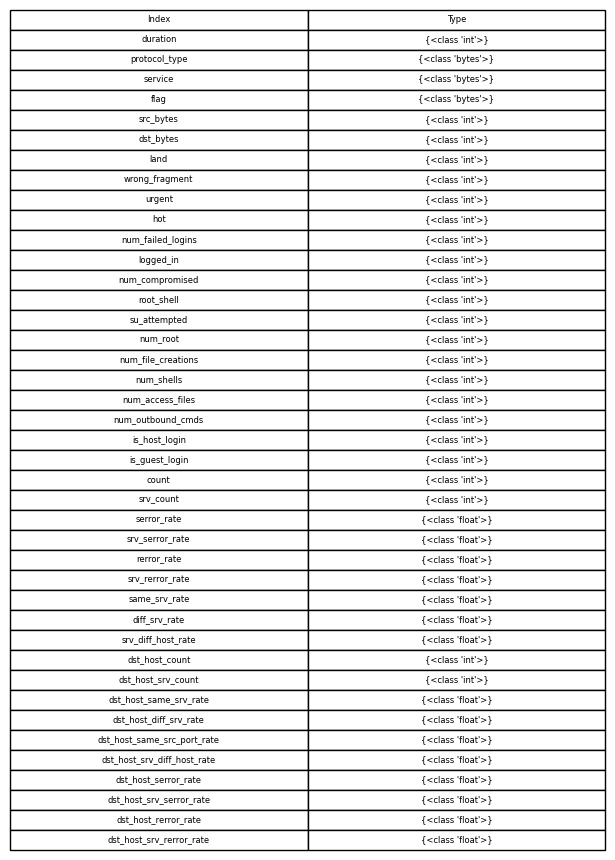

In [16]:
types_str = [str(t) for t in typeElement]
# Create a table
fig, ax = plt.subplots()

# Hide the axes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create the table
table_data = [[attributes[i], types_str[i]] for i in range(len(types_str))]
column_labels = ("Index", "Type")
table = ax.table(cellText=table_data, colLabels=column_labels, cellLoc='center', loc='center')

# Adjust the table
table.auto_set_font_size(False)
table.set_fontsize(6)
table.scale(1.2, 1.2)


Look for the unique variables over the attributes using parallel processing

In [17]:
%%time
uniquesParallel = []
for i in range(41):
    s = RddX.map(lambda x: x[i])\
        .distinct()\
        .count()
    uniquesParallel.append(s)

RddX.unpersist()

CPU times: user 165 ms, sys: 57.2 ms, total: 223 ms
Wall time: 13.9 s


PythonRDD[1] at RDD at PythonRDD.scala:53

In [18]:
print("The number of uniques is", uniquesParallel)

The number of uniques is [58, 3, 46, 5, 358, 570, 1, 3, 1, 6, 1, 2, 3, 1, 1, 4, 2, 1, 2, 1, 1, 2, 311, 136, 20, 11, 23, 14, 42, 34, 42, 197, 191, 95, 59, 64, 38, 22, 8, 37, 29]


Look for the unique variables over the attributes in local

In [19]:
%%time
uniques = []
for i in range (x.shape[1]):
    k = (len(np.unique(x[:, i])))
    uniques.append(k)
print("The uniques are:", uniques)

The uniques are: [58, 3, 46, 5, 358, 570, 1, 3, 1, 6, 1, 2, 3, 1, 1, 4, 2, 1, 2, 1, 1, 2, 311, 136, 20, 11, 23, 14, 42, 34, 42, 197, 191, 95, 59, 64, 38, 22, 8, 37, 29]
CPU times: user 54.2 ms, sys: 1.57 ms, total: 55.8 ms
Wall time: 55.1 ms


It takes 4 times for to do it in parallel (explain what is better to use)

why running it a second time takes way more time?

In [20]:
%%time
RddY = Rdd.map(lambda datum: datum[1]["y"]).persist()

kTrue = RddY.distinct()\
        .count()

CPU times: user 3.93 ms, sys: 4.3 ms, total: 8.23 ms
Wall time: 433 ms


In [21]:
print("The true number of the classes is", kTrue)

The true number of the classes is 10


Unique number of labels in parallel

In [22]:
%%time
uniquesParallely = RddY.countByValue()
RddY.unpersist()

print("The y things are:", uniquesParallely)

The y things are: defaultdict(<class 'int'>, {b'smurf.': 2800, b'neptune.': 1119, b'normal.': 996, b'ipsweep.': 10, b'satan.': 17, b'warezclient.': 11, b'pod.': 3, b'portsweep.': 10, b'teardrop.': 14, b'back.': 20})
CPU times: user 2.71 ms, sys: 820 µs, total: 3.53 ms
Wall time: 151 ms


In [23]:
yUnique = [a.decode('utf-8') for a in uniquesParallely.keys()]
xUnique = list(uniquesParallely.values())

Plot of the count of the ocurency of the uniques of label and attributes

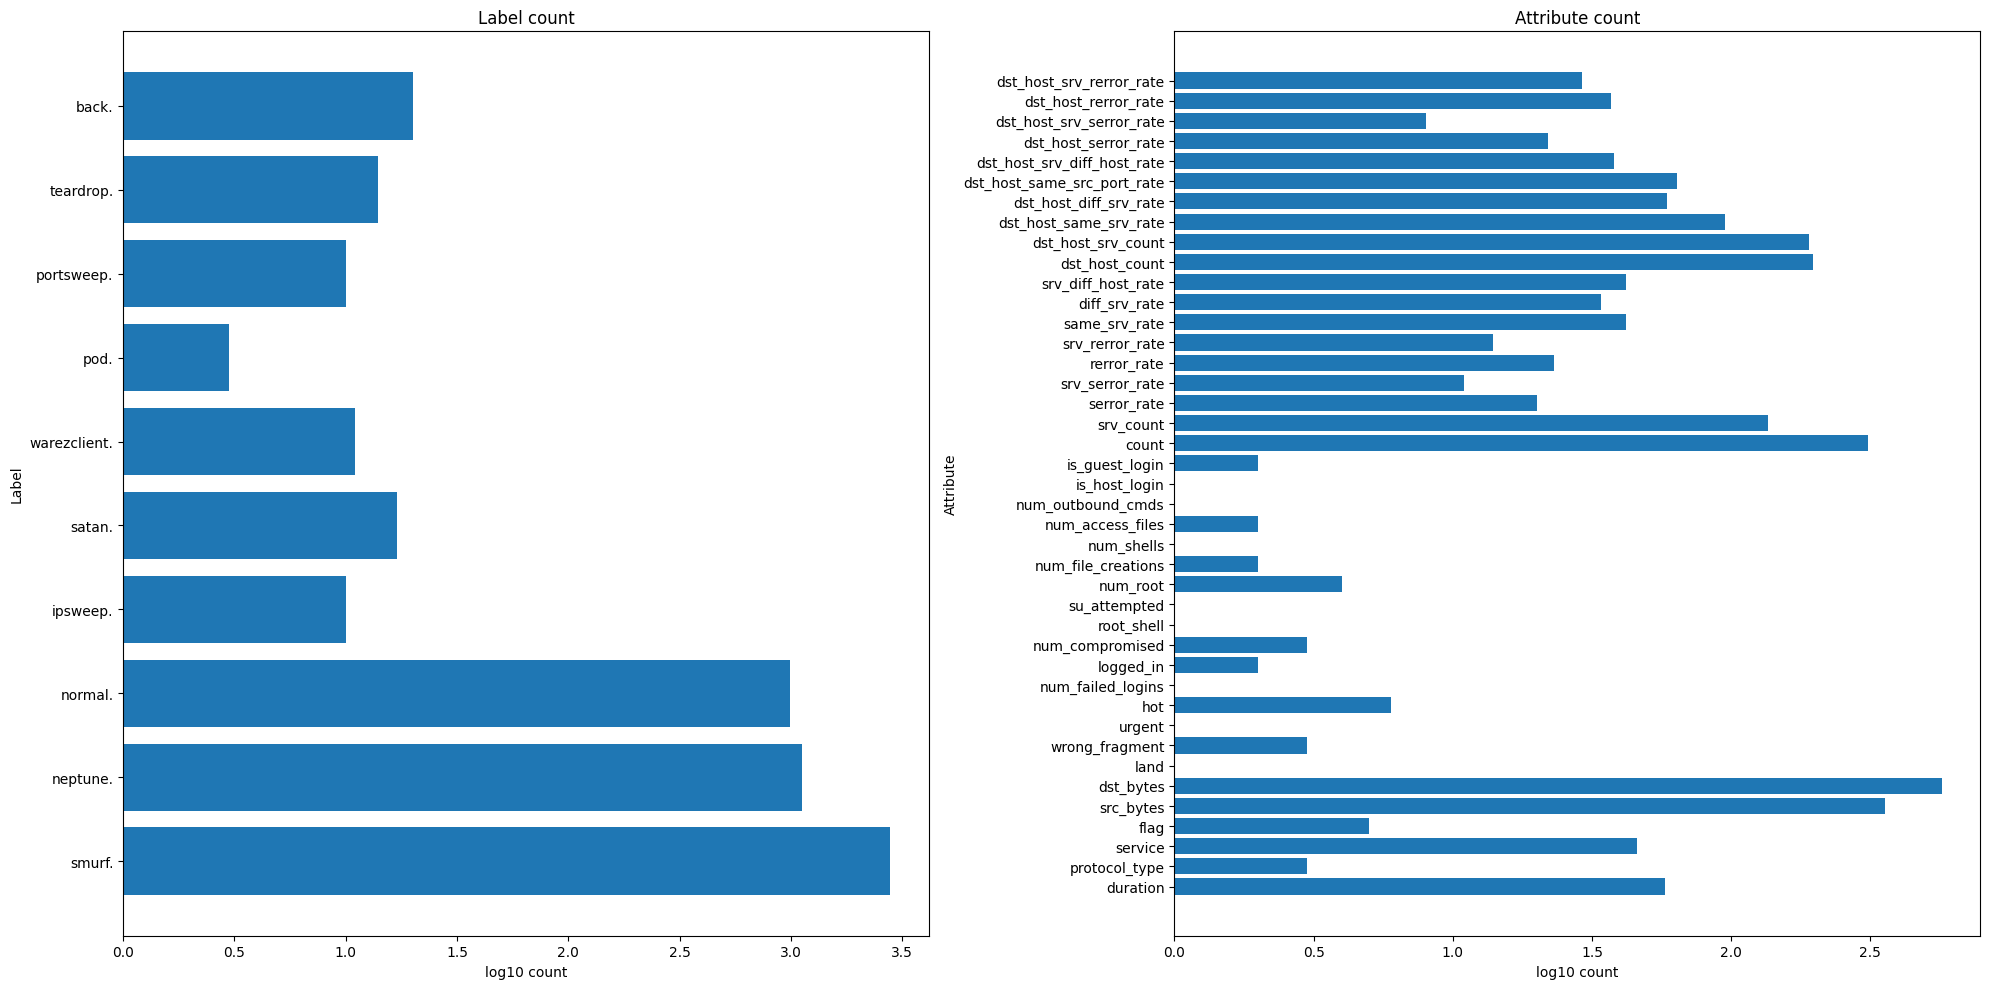

In [24]:
# add log 10 the ax and npt the count
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].barh(yUnique, np.log10(xUnique))
ax[0].set_xlabel("log10 count")
ax[0].set_ylabel("Label")
ax[0].set_title("Label count")
ax[1].barh(attributes, np.log10(uniquesParallel))
ax[1].set_xlabel("log10 count")
ax[1].set_ylabel("Attribute")
ax[1].set_title("Attribute count")
fig.tight_layout()

In [25]:
Rdd = Rdd.map(deleteBytes)\
         .persist()

In [26]:
numberColumns = len([i for i in typeElement if i != set([bytes])])
print("The number of columns (dimensionality) after filtering the bytes is", numberColumns)

The number of columns (dimensionality) after filtering the bytes is 38


# PARALLEL PART

In [27]:
%%time
maxS = Rdd.map(lambda datum: datum[1]["x"])\
           .reduce(lambda a, b: np.maximum(a, b))
minS = Rdd.map(lambda datum: datum[1]["x"])\
           .reduce(lambda a, b: np.minimum(a, b))

Rdd = Rdd.map(lambda datum: minmaxRescale(datum, minS, maxS))\
         .persist()

CPU times: user 7.57 ms, sys: 3.32 ms, total: 10.9 ms
Wall time: 789 ms


In [28]:
%%time

logParallelInit = {}
logParallelKmeans = {}

k=kTrue
l=k*2 # rescaling probability to have more centroids than k

# inizialize the centroids with kmeans parallel and compute C after the iterations
C_init = parallelInit(Rdd, k, l, logParallelInit)
C = kMeans(Rdd, C_init, 15, logParallelKmeans)
Rdd=Rdd.map(lambda datum: selectCluster(datum, C))

CPU times: user 1.02 s, sys: 62.9 ms, total: 1.08 s
Wall time: 44 s


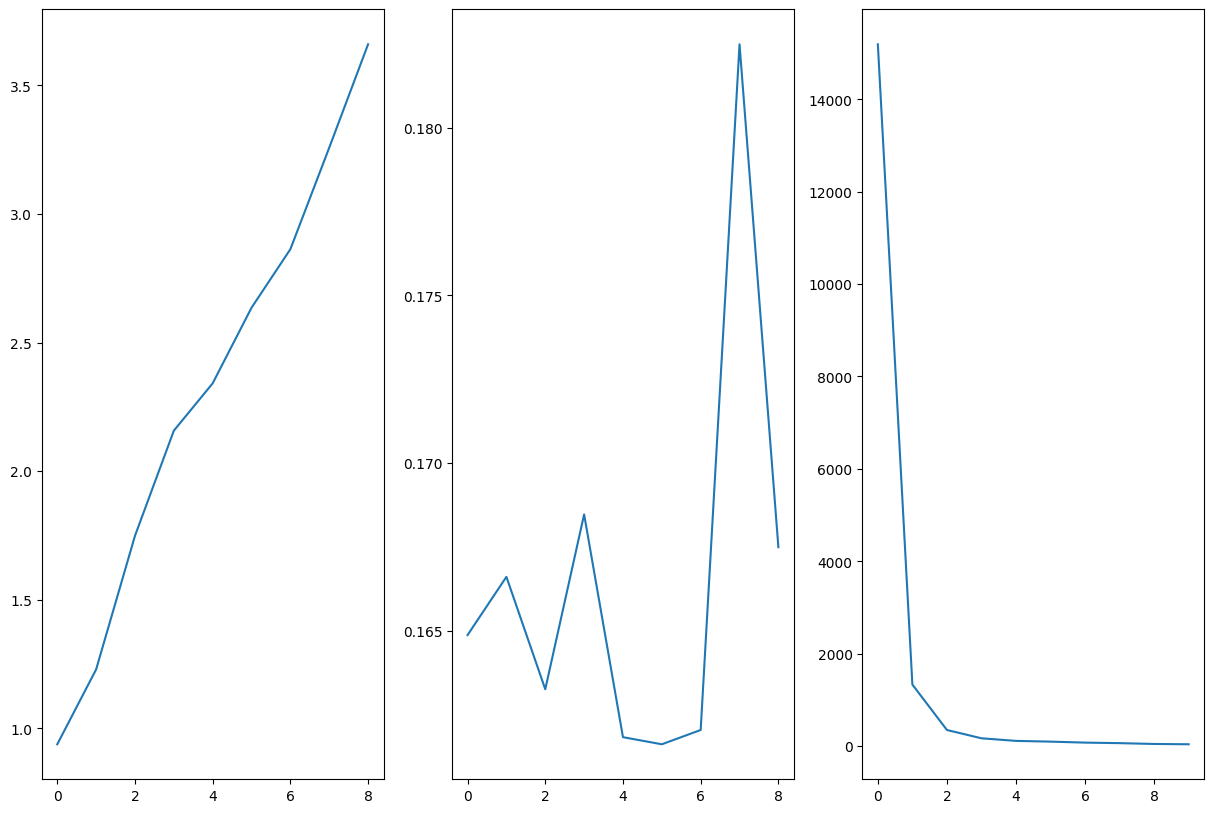

In [29]:
fig, ax=plt.subplots(1,3, figsize=(15,10))
ax[0].plot(logParallelInit["tCentroids"])
ax[1].plot(logParallelInit["tSamples"])
ax[2].plot(logParallelInit["CostInit"])

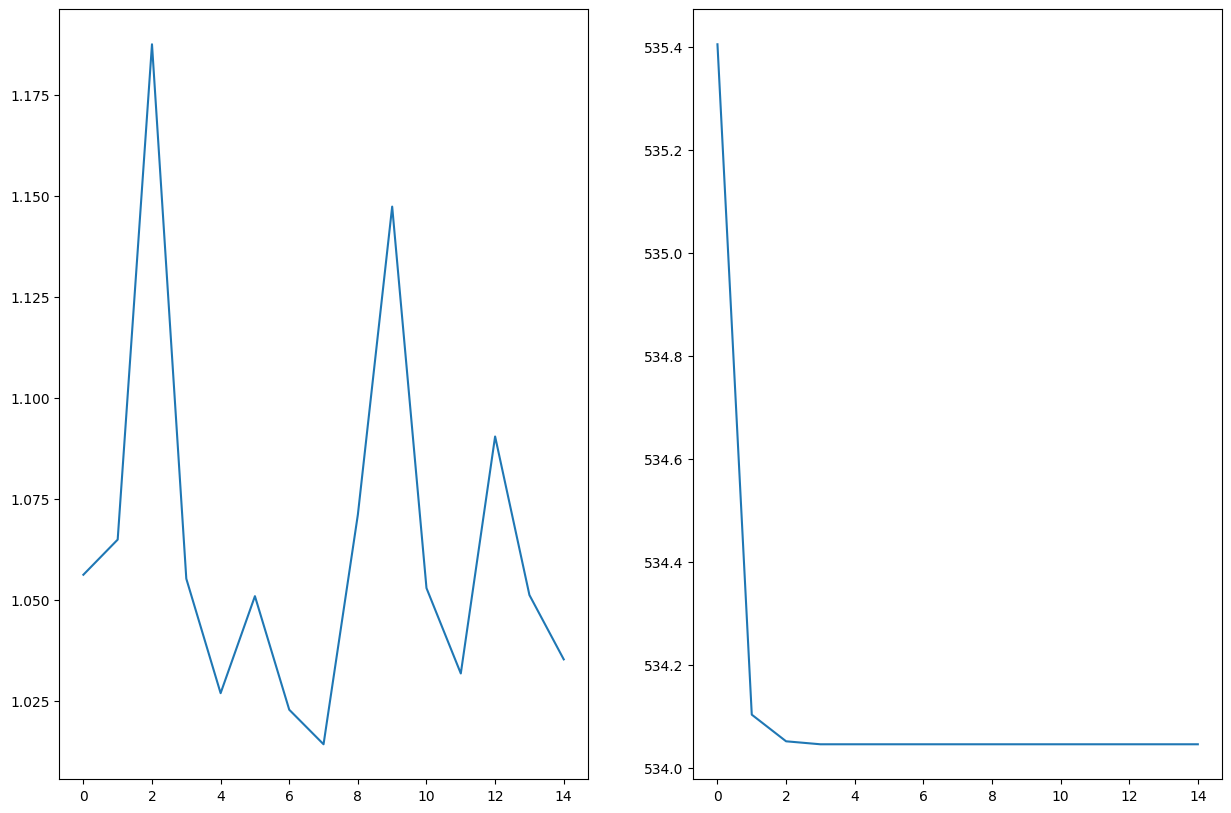

In [30]:
fig, ax=plt.subplots(1,2, figsize=(15,10))
ax[0].plot(logParallelKmeans["tIterations"])
ax[1].plot(logParallelKmeans["CostsKmeans"])

# AGREEMENT BETWEEN EXPECTED CLUSTER LABELS Y AND RESULTED LABELS CLUSTERLD

In [46]:
C_predicted=C
expectedRdd=Rdd.map(lambda datum:(labelToInt(datum[1]['y']), datum[1])) #put y-label as clusterId
C_expected=updateCentroids(expectedRdd) #compute centroids coordinate
expectedRdd=updateDistances(expectedRdd, C_expected) #update and save squared distances points-centroids
print(expectedRdd.take(1))

[(7, {'x': array([0.0, 0.009689958874011756, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0,
       0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], dtype=object), 'y': b'smurf.', 'd2': 4.018310300876129})]


First, we compare the cluster populations

predictedPopulationDict {0: 2800, 5: 908, 1: 432, 8: 418, 7: 238, 6: 99, 2: 51, 3: 47, 4: 5, 9: 2}


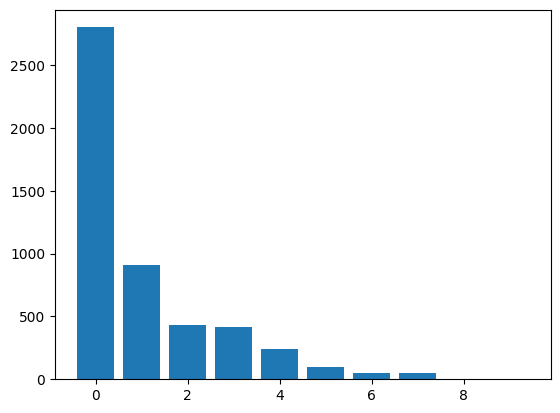

expectedPopulationDict {b'smurf.': 2800, b'neptune.': 1119, b'normal.': 996, b'back.': 20, b'satan.': 17, b'teardrop.': 14, b'warezclient.': 11, b'ipsweep.': 10, b'portsweep.': 10, b'pod.': 3}


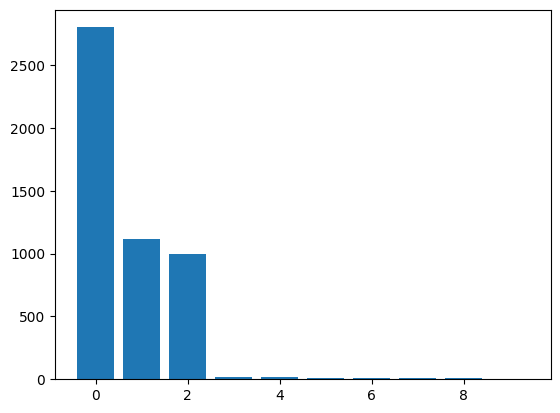

In [32]:
predictedPopulationDict=Rdd.countByKey()
predictedPopulationDict = dict(sorted(predictedPopulationDict.items(), key=lambda item: item[1], reverse=True))
expectedPopulationDict=Rdd.map(lambda datum:(datum[1]['y'], datum[1])).countByKey()
expectedPopulationDict = dict(sorted(expectedPopulationDict.items(), key=lambda item: item[1], reverse=True))
print('predictedPopulationDict', predictedPopulationDict)
plt.bar(np.arange(len(predictedPopulationDict)), predictedPopulationDict.values())
plt.show()
print('expectedPopulationDict',expectedPopulationDict)
plt.bar(np.arange(len(expectedPopulationDict)), expectedPopulationDict.values())
plt.show()

Now we want to calculate the mean square error between expected centroids and the nearest predicted centroids.

In [43]:
print('k_expected, k_predicted: ', len(C_expected), len(C_predicted))

labeler, distancesPredictedExpected=predictedCentroidsLabeler(C_expected, C_predicted)
meanSquaredError=np.sum(distancesPredictedExpected**2)/len(distancesPredictedExpected)
print('Index of nearest predicted centroid to each expected centroid: \n', labeler)
print('Distances between expected centroids and nearest predicted centroids: \n', distancesPredictedExpected)
print('MeanSquaredError: ', meanSquaredError)

k_expected, k_predicted:  10 10
Index of nearest predicted centroid to each expected centroid: 
 [5 7 3 6 1 0 1 3 3 7]
Distances between expected centroids and nearest predicted centroids: 
 [5.38138426e-01 1.29393950e+00 6.19810327e-01 1.02338445e+00
 7.88850433e-01 3.32760632e-04 4.71922652e-01 6.76484265e-01
 8.26554706e-01 1.23484354e+00]
MeanSquaredError:  0.6906011294737457


In [37]:
#standard deviation of cluster from expected centroids
#stdExpected=updateDistances(Rdd.map(lambda datum: (datum[1]['y'], datum[1])), C_expected).collect()
stdExpected=expectedRdd.mapValues(lambda datum1: (datum1['d2'], 1))\
                        .reduceByKey(lambda a,b : (a[0]+b[0], a[1]+b[1]))\
                        .mapValues(lambda a:np.sqrt(a[0]/a[1]))\
                        .collect()
stdExpected=list(zip(*stdExpected))
print(stdExpected)

[(2, 6, 4, 8, 0, 7, 3, 1, 9, 5), (2.9338187078658016, 2.9606254334670776, 2.1053743205696356, 1.9437798083435112, 2.680085109435321, 1.997314247602695, 1.7930355102333975, 3.333654148317523, 2.602395520421487, 2.9291115539795607)]


In the following plot we show:
- with blue errorbars the standard deviation of expected cluster with respect to expected centroids;
- with blue boxes the distances to each expected centroid of its nearest **expected** centroid
- with red bars the distances to each expected centroid of its nearest **predicted** centroid;

[5.38138426e-01 1.29393950e+00 6.19810327e-01 1.02338445e+00
 7.88850433e-01 3.32760632e-04 4.71922652e-01 6.76484265e-01
 8.26554706e-01 1.23484354e+00]


<BarContainer object of 10 artists>

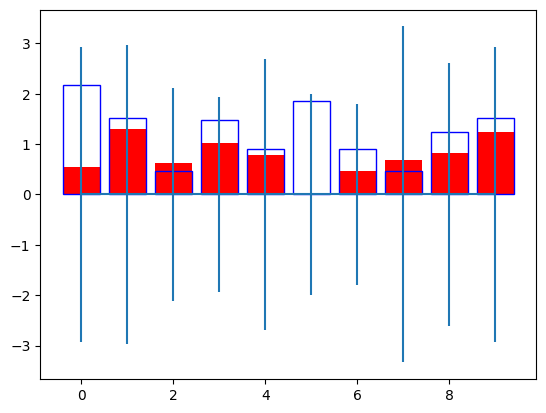

In [38]:
plt.errorbar(np.arange(len(C_expected)), np.zeros(shape=(len(stdExpected[0]))), stdExpected[1])
print(distancesPredictedExpected)
plt.bar(np.arange(len(C_expected)), distancesPredictedExpected, color='red')
plt.bar(np.arange(len(C_expected)), nearestCentroidDistances(C_expected)[1], edgecolor='blue', facecolor='none')

# BENCHMARKS

## IMPORT THE DATA AND DESCRIPTION

In [2]:
filesP = os.listdir("dataP")
filesR = os.listdir("dataR")

In [3]:
totalLogP = []
for file in filesP:
    pathFile = os.path.join("dataP", file)
    with open(pathFile, 'rb') as f:
        s = pickle.load(f)
    totalLogP.append(s)

totalLogR = []
for file in filesR:
    pathFile = os.path.join("dataR", file)
    with open(pathFile, 'rb') as f:
        s = pickle.load(f)
    totalLogR.append(s)

This is the structure of the logParallel dictionary:

In [4]:
len(totalLogP)

2

In [5]:
print(totalLogP[0].keys())

dict_keys(['totalLogParallelInit', 'totalLogParallelKmeans', 'tDurationsParallel', 'tPreOperationsParallel'])


In [6]:
print(totalLogP[0]["totalLogParallelInit"].keys())
print(totalLogP[0]["totalLogParallelKmeans"].keys())
print(totalLogP[0]["tDurationsParallel"].keys())
print(totalLogP[0]["tPreOperationsParallel"].keys())

dict_keys(['Number of partition1', 'Number of partition2'])
dict_keys(['Number of partition1', 'Number of partition2'])
dict_keys(['Number of partition1', 'Number of partition2'])
dict_keys(['Number of partition1', 'Number of partition2'])


In [7]:
print(totalLogP[0]["totalLogParallelInit"]['Number of partition1'].keys())
print(totalLogP[0]["totalLogParallelInit"]['Number of partition1']['tTotal'])
print(totalLogP[0]["totalLogParallelInit"]['Number of partition1']['tSamples'])
print(totalLogP[0]["totalLogParallelInit"]['Number of partition1']['tCentroids'])
print(totalLogP[0]["totalLogParallelInit"]['Number of partition1']['CostInit'])

print(totalLogP[0]["totalLogParallelKmeans"]['Number of partition1'].keys())
print(totalLogP[0]["totalLogParallelKmeans"]['Number of partition1']['tTotal'])
print(totalLogP[0]["totalLogParallelKmeans"]['Number of partition1']['tIterations'])
print(totalLogP[0]["totalLogParallelKmeans"]['Number of partition1']['CostsKmeans'])

print(totalLogP[0]["tDurationsParallel"]["Number of partition1"])
print(totalLogP[0]["tPreOperationsParallel"]["Number of partition1"])

dict_keys(['tSamples', 'tCentroids', 'CostInit', 'tTotal'])
5.867350101470947
[0.08321571350097656, 0.14698100090026855, 0.22282767295837402, 0.3588082790374756, 0.4491755962371826, 0.5802628993988037]
[0.13881349563598633, 0.23493552207946777, 0.35022759437561035, 0.4490840435028076, 0.5860741138458252, 0.7492508888244629]
[823.1009900744178, 347.1856658304473, 247.06864577820335, 156.842953561549, 149.51346088848717, 137.35362393336464, 124.08865127714856]
dict_keys(['CostsKmeans', 'tIterations', 'tTotal'])
15.004190921783447
[0.3352344036102295, 0.4065067768096924, 0.5334022045135498, 0.6299893856048584, 0.7322332859039307, 0.8090987205505371, 0.8878521919250488, 1.01023530960083, 1.1183063983917236, 1.2148358821868896, 1.2315893173217773, 1.3682255744934082, 1.417729139328003, 1.5992560386657715, 1.7096774578094482]
[406.9738089335353, 406.9657051115516, 406.9644822730015, 406.9644822730015, 406.9644822730015, 406.9644822730015, 406.9644822730015, 406.9644822730015, 406.96448227300

This is the structure of the logRandom dictionary

In [8]:
len(totalLogR)

2

In [9]:
print(totalLogR[0].keys())

dict_keys(['totalLogNaiveInit', 'totalLogNaiveKmeans', 'tDurationsNaive', 'tPreOperationsNaive'])


In [10]:
print(totalLogR[0]["totalLogNaiveInit"].keys())
print(totalLogR[0]["totalLogNaiveKmeans"].keys())
print(totalLogR[0]["tDurationsNaive"].keys())
print(totalLogR[0]["tPreOperationsNaive"].keys())

dict_keys(['Number of partition1', 'Number of partition2'])
dict_keys(['Number of partition1', 'Number of partition2'])
dict_keys(['Number of partition1', 'Number of partition2'])
dict_keys(['Number of partition1', 'Number of partition2'])


In [11]:
print(totalLogR[0]["totalLogNaiveInit"]['Number of partition1'].keys())
print(totalLogR[0]["totalLogNaiveInit"]['Number of partition1']['tTotal'])

print(totalLogR[0]["totalLogNaiveKmeans"]['Number of partition1'].keys())
print(totalLogR[0]["totalLogNaiveKmeans"]['Number of partition1']['tTotal'])
print(totalLogR[0]["totalLogNaiveKmeans"]['Number of partition1']['tIterations'])
print(totalLogR[0]["totalLogNaiveKmeans"]['Number of partition1']['CostsKmeans'])

print(totalLogR[0]["tDurationsNaive"]["Number of partition1"])
print(totalLogR[0]["tPreOperationsNaive"]["Number of partition1"])

dict_keys(['tTotal'])
0.27451276779174805
dict_keys(['CostsKmeans', 'tIterations', 'tTotal'])
14.176602602005005
[0.30933308601379395, 0.3904902935028076, 0.4900245666503906, 0.5928242206573486, 0.6819806098937988, 0.7736868858337402, 0.8341593742370605, 0.9377224445343018, 1.0629732608795166, 1.0988662242889404, 1.2323634624481201, 1.3276400566101074, 1.4043469429016113, 1.5013384819030762, 1.538839340209961]
[501.25906355981874, 459.11204302625094, 445.1363300545453, 436.8039766075408, 433.89428659613617, 433.29792226882233, 433.14124937398293, 433.11846468548725, 432.7126346433218, 432.50083689925134, 432.47495454524045, 432.4726496776249, 432.470867325149, 432.470867325149, 432.470867325149]
14.899076223373413
0.4478013515472412


## GRAFICI E PLOT

In [12]:
print(totalLogP[0]["totalLogParallelKmeans"]['Number of partition1']['CostsKmeans'])
print(totalLogP[1]["totalLogParallelKmeans"]['Number of partition1']['CostsKmeans'])

[406.9738089335353, 406.9657051115516, 406.9644822730015, 406.9644822730015, 406.9644822730015, 406.9644822730015, 406.9644822730015, 406.9644822730015, 406.9644822730015, 406.9644822730015, 406.9644822730015, 406.9644822730015, 406.9644822730015, 406.9644822730015, 406.9644822730015]
[425.6911182688906, 425.6657891053657, 425.19512163463327, 425.1020659083087, 425.0835977168268, 425.08094863239836, 425.0791291568962, 425.0791291568962, 425.0791291568962, 425.0791291568962, 425.0791291568962, 425.0791291568962, 425.0791291568962, 425.0791291568962, 425.0791291568962]


In [13]:
# Calculate the mean of Kmeans costs parallel
costs_lists = [item["totalLogParallelKmeans"]['Number of partition1']['CostsKmeans'] for item in totalLogP]
costs_array = np.array(costs_lists)

# Calculate the mean and standard deviation  parallel
meansP = np.mean(costs_array, axis=0)
stdDevsP = np.std(costs_array, axis=0)

print("Means:", meansP)
print("Standard Deviations:", stdDevsP)

# Calculate the mean of Kmeans costs naive
costs_lists = [item["totalLogNaiveKmeans"]['Number of partition1']['CostsKmeans'] for item in totalLogR]
costs_array = np.array(costs_lists)

# Calculate the mean and standard deviation naive
meansN = np.mean(costs_array, axis=0)
stdDevsN = np.std(costs_array, axis=0)

print("Means:", meansN)
print("Standard Deviations:", stdDevsN)

Means: [416.3324636  416.31574711 416.07980195 416.03327409 416.02403999
 416.02271545 416.02180571 416.02180571 416.02180571 416.02180571
 416.02180571 416.02180571 416.02180571 416.02180571 416.02180571]
Standard Deviations: [9.35865467 9.350042   9.11531968 9.06879182 9.05955772 9.05823318
 9.05732344 9.05732344 9.05732344 9.05732344 9.05732344 9.05732344
 9.05732344 9.05732344 9.05732344]
Means: [480.27806252 442.68132338 431.60912794 424.59495844 422.09432978
 421.63331428 421.54654799 421.53377539 421.32867278 421.22277391
 421.20983274 421.2086803  421.20778913 421.20778913 421.20778913]
Standard Deviations: [20.98100104 16.43071965 13.52720212 12.20901817 11.79995682 11.66460799
 11.59470138 11.58468929 11.38396186 11.27806299 11.26512181 11.26396938
 11.2630782  11.2630782  11.2630782 ]


This is done with the best number of partition
But what is best? Time to solve the problem? Final cost?

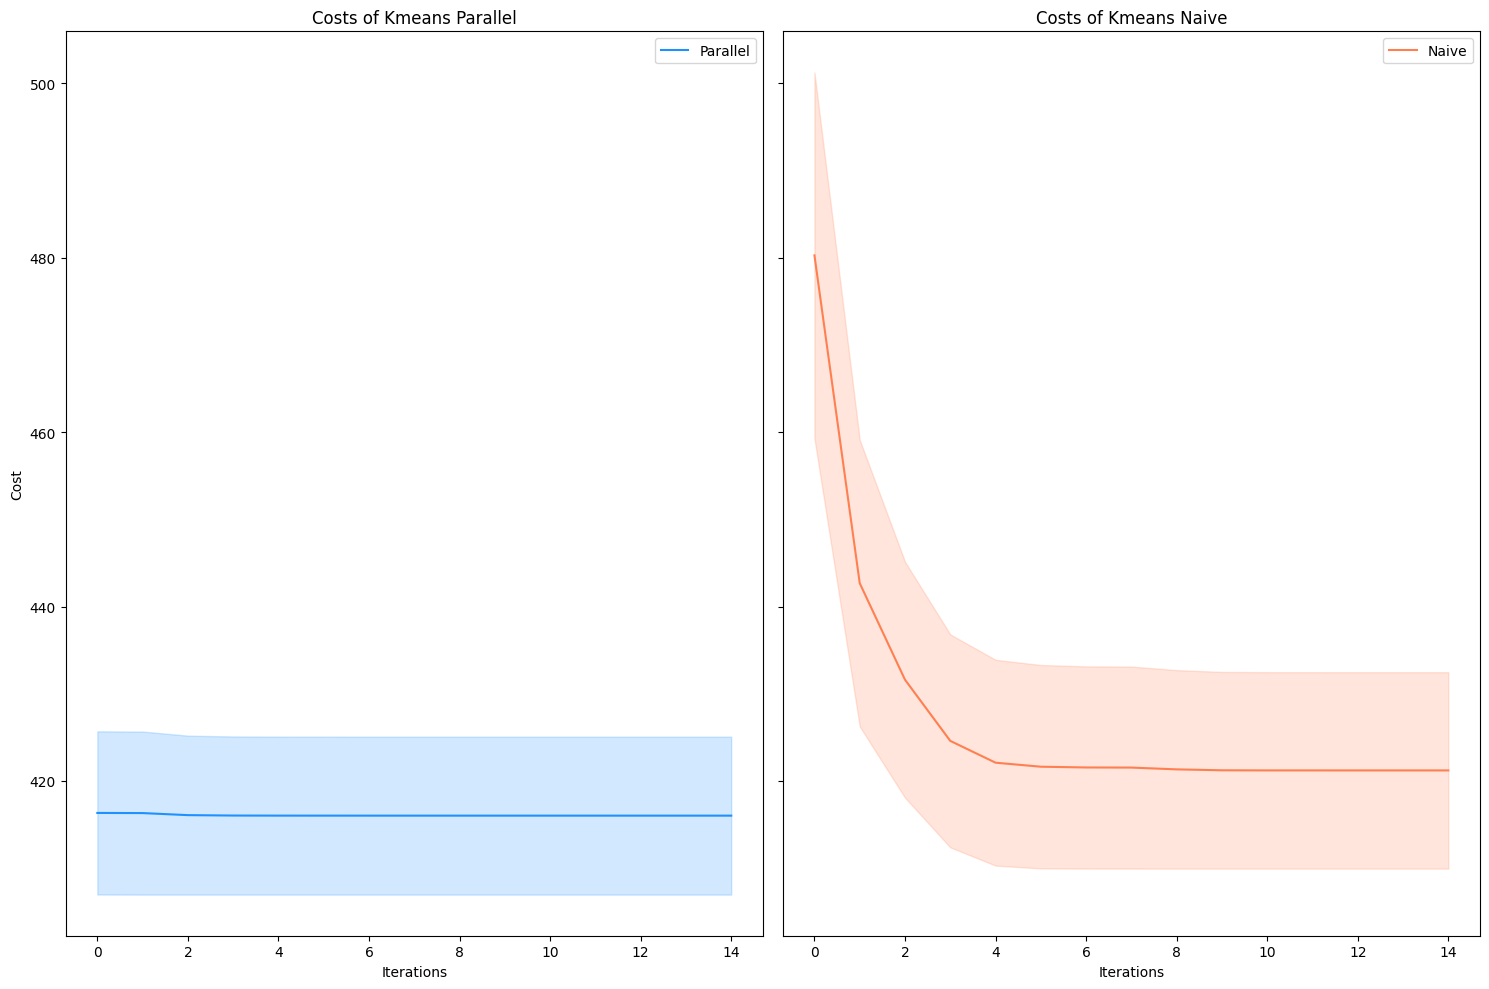

In [14]:
# plot the cost of the kmeans for the parallel also showhing the standard deviation for bothe the parallel and the naive initialization
fig, ax = plt.subplots(1, 2, figsize=(15, 10), sharey=True)  # Add sharey=True to share the Y axis
colorP = "dodgerblue"  # A nicer color for Parallel
colorN = "coral"  # A nicer color for Naive

ax[0].plot(meansP, label="Parallel", color=colorP)
ax[0].fill_between(np.arange(len(meansP)), meansP - stdDevsP, meansP + stdDevsP, color=colorP, alpha=0.2)
ax[0].set_title("Costs of Kmeans Parallel")
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Cost")
ax[0].legend()

ax[1].plot(meansN, label="Naive", color=colorN)
ax[1].fill_between(np.arange(len(meansN)), meansN - stdDevsN, meansN + stdDevsN, color=colorN, alpha=0.2)
ax[1].set_title("Costs of Kmeans Naive")
ax[1].set_xlabel("Iterations")
# ax[1].set_ylabel("Cost")  # This is not needed anymore because of sharey=True
ax[1].legend()

fig.tight_layout()



Il plot mostra l'andamento del costo durante le iterazioni, prendendo la media e la devisìazione standard delle simulazioni fatte

In [15]:
# Grafico a Barre per Tempi di Esecuzione

initPduration = [[totalLogP[i]["totalLogParallelInit"][part]["tTotal"] for i in range (len(totalLogP))] for part in totalLogP[0]["totalLogParallelInit"]]
initPduration = np.array(initPduration)
meanPinit = np.mean(initPduration, axis=1)
stdPinit = np.std(initPduration, axis=1)

totalPduration = [[totalLogP[i]["tDurationsParallel"][part] for i in range (len(totalLogP))] for part in totalLogP[0]["tDurationsParallel"]]
totalPduration = np.array(totalPduration)
meanPtotal = np.mean(totalPduration, axis=1)
stdPTotal = np.std(totalPduration, axis=1)

kmeansPduration = [[totalLogP[i]["totalLogParallelKmeans"][part]["tTotal"] for i in range (len(totalLogP))] for part in totalLogP[0]["totalLogParallelKmeans"]]
kmeansPduration = np.array(kmeansPduration)
meanPkmeans = np.mean(kmeansPduration, axis=1)
stdPkmeans = np.std(kmeansPduration, axis=1)

prePduration = [[totalLogP[i]["tPreOperationsParallel"][part] for i in range (len(totalLogP))] for part in totalLogP[0]["tPreOperationsParallel"]]
prePduration = np.array(prePduration)
meanPpre = np.mean(prePduration, axis=1)
stdPpre = np.std(prePduration, axis=1)

In [16]:
initRduration = [[totalLogR[i]["totalLogNaiveInit"][part]["tTotal"] for i in range (len(totalLogR))] for part in totalLogR[0]["totalLogNaiveInit"]]
initRduration = np.array(initRduration)
meanRinit = np.mean(initRduration, axis=1)
stdRinit = np.std(initRduration, axis=1)

kmeansRduration = [[totalLogR[i]["totalLogNaiveKmeans"][part]["tTotal"] for i in range (len(totalLogR))] for part in totalLogR[0]["totalLogNaiveKmeans"]]
kmeansRduration = np.array(kmeansRduration)
meanRkmeans = np.mean(kmeansRduration, axis=1)
stdRkmeans = np.std(kmeansRduration, axis=1)

preRduration = [[totalLogR[i]["tPreOperationsNaive"][part] for i in range (len(totalLogR))] for part in totalLogR[0]["tPreOperationsNaive"]]
preRduration = np.array(preRduration)
meanRpre = np.mean(preRduration, axis=1)
stdRpre = np.std(preRduration, axis=1)

totalRduration = [[totalLogR[i]["tDurationsNaive"][part] for i in range (len(totalLogR))] for part in totalLogR[0]["tDurationsNaive"]]
totalRduration = np.array(totalRduration)
meanRtotal = np.mean(totalRduration, axis=1)
stdRTotal = np.std(totalRduration, axis=1)


In [17]:
meanPinit, meanPtotal, meanPkmeans , meanPpre

(array([6.54548228, 7.36545861]),
 array([22.93976557, 25.14162195]),
 array([15.18177128, 16.91514027]),
 array([1.21231318, 0.8607899 ]))

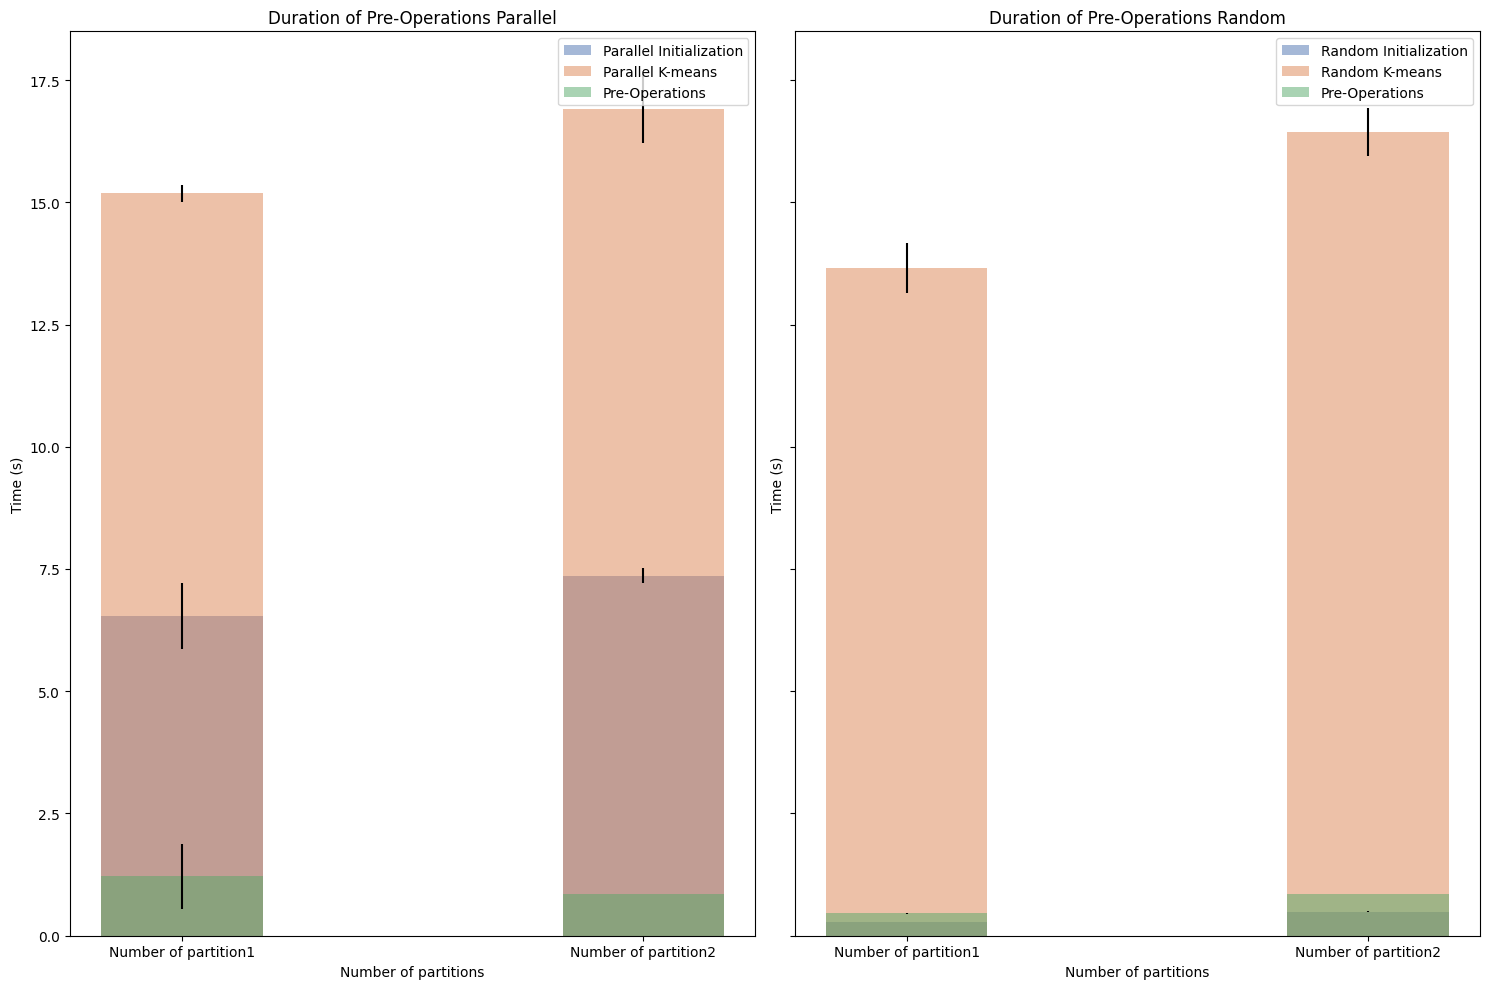

In [18]:
colorPalette = sns.color_palette("deep")  
# Impostare colori più chiari
colorInit = colorPalette[0]
colorKmeans = colorPalette[1]
colorPre = colorPalette[2]
color = colorPalette[3]

# Creare il plot in modo più sintetico
fig, ax = plt.subplots(1, 2, figsize=(15, 10), sharey=True)
barWidth = 0.35
indices = range(len(totalLogP[0]["totalLogParallelInit"]))

# Funzione per semplificare la creazione dei subplot
def create_subplot(ax, indices, mean, std, title, label, color):
    ax.bar(indices, mean, barWidth, yerr=std, label=label, color=color, alpha=0.5)
    ax.set_title(title)
    ax.set_xlabel("Number of partitions")
    ax.set_ylabel("Time (s)")
    ax.legend()
    ax.set_xticks(indices)
    ax.set_xticklabels(totalLogP[0]["totalLogParallelInit"].keys())

# Applicare la funzione ai subplot
create_subplot(ax[0], indices, meanPinit, stdPinit, "Duration of Parallel Initialization", "Parallel Initialization", colorInit)
create_subplot(ax[0], indices, meanPkmeans, stdPkmeans, "", "Parallel K-means", colorKmeans)
create_subplot(ax[0], indices, meanPpre, stdPpre, "Duration of Pre-Operations Parallel", "Pre-Operations", colorPre)
create_subplot(ax[1], indices, meanRinit, stdRinit, "Duration of Random Initialization", "Random Initialization", colorInit)
create_subplot(ax[1], indices, meanRkmeans, stdRkmeans, "", "Random K-means", colorKmeans)
create_subplot(ax[1], indices, meanRpre, stdRpre, "Duration of Pre-Operations Random", "Pre-Operations", colorPre)

plt.tight_layout()

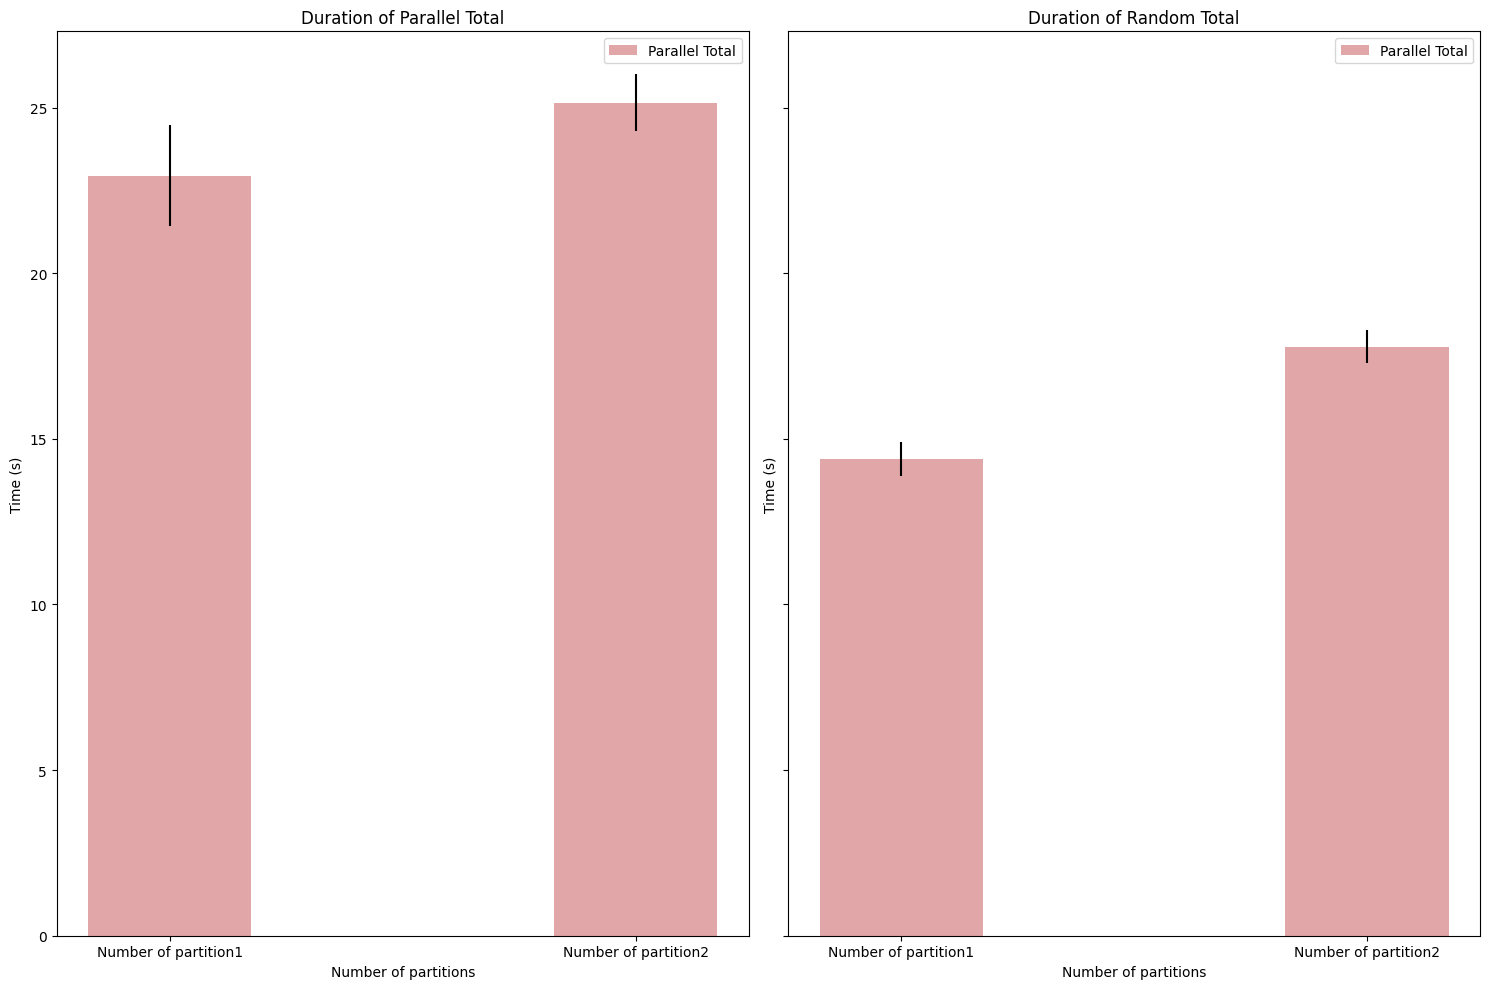

In [19]:
colorPalette = sns.color_palette("deep")  
# Impostare colori più chiari
colorInit = colorPalette[0]
colorKmeans = colorPalette[1]
colorPre = colorPalette[2]
color = colorPalette[3]

# Creare il plot in modo più sintetico
fig, ax = plt.subplots(1, 2, figsize=(15, 10), sharey=True)
barWidth = 0.35
indices = range(len(totalLogR[0]["totalLogNaiveInit"]))

# Funzione per semplificare la creazione dei subplot
def create_subplot(ax, indices, mean, std, title, label, color):
    ax.bar(indices, mean, barWidth, yerr=std, label=label, color=color, alpha=0.5)
    ax.set_title(title)
    ax.set_xlabel("Number of partitions")
    ax.set_ylabel("Time (s)")
    ax.legend()
    ax.set_xticks(indices)
    ax.set_xticklabels(totalLogP[0]["totalLogParallelInit"].keys())

# Applicare la funzione ai subplot

create_subplot(ax[0], indices, meanPtotal, stdPTotal, "Duration of Parallel Total", "Parallel Total", color)
create_subplot(ax[1], indices, meanRtotal, stdRTotal, "Duration of Random Total", "Parallel Total", color)

plt.tight_layout()

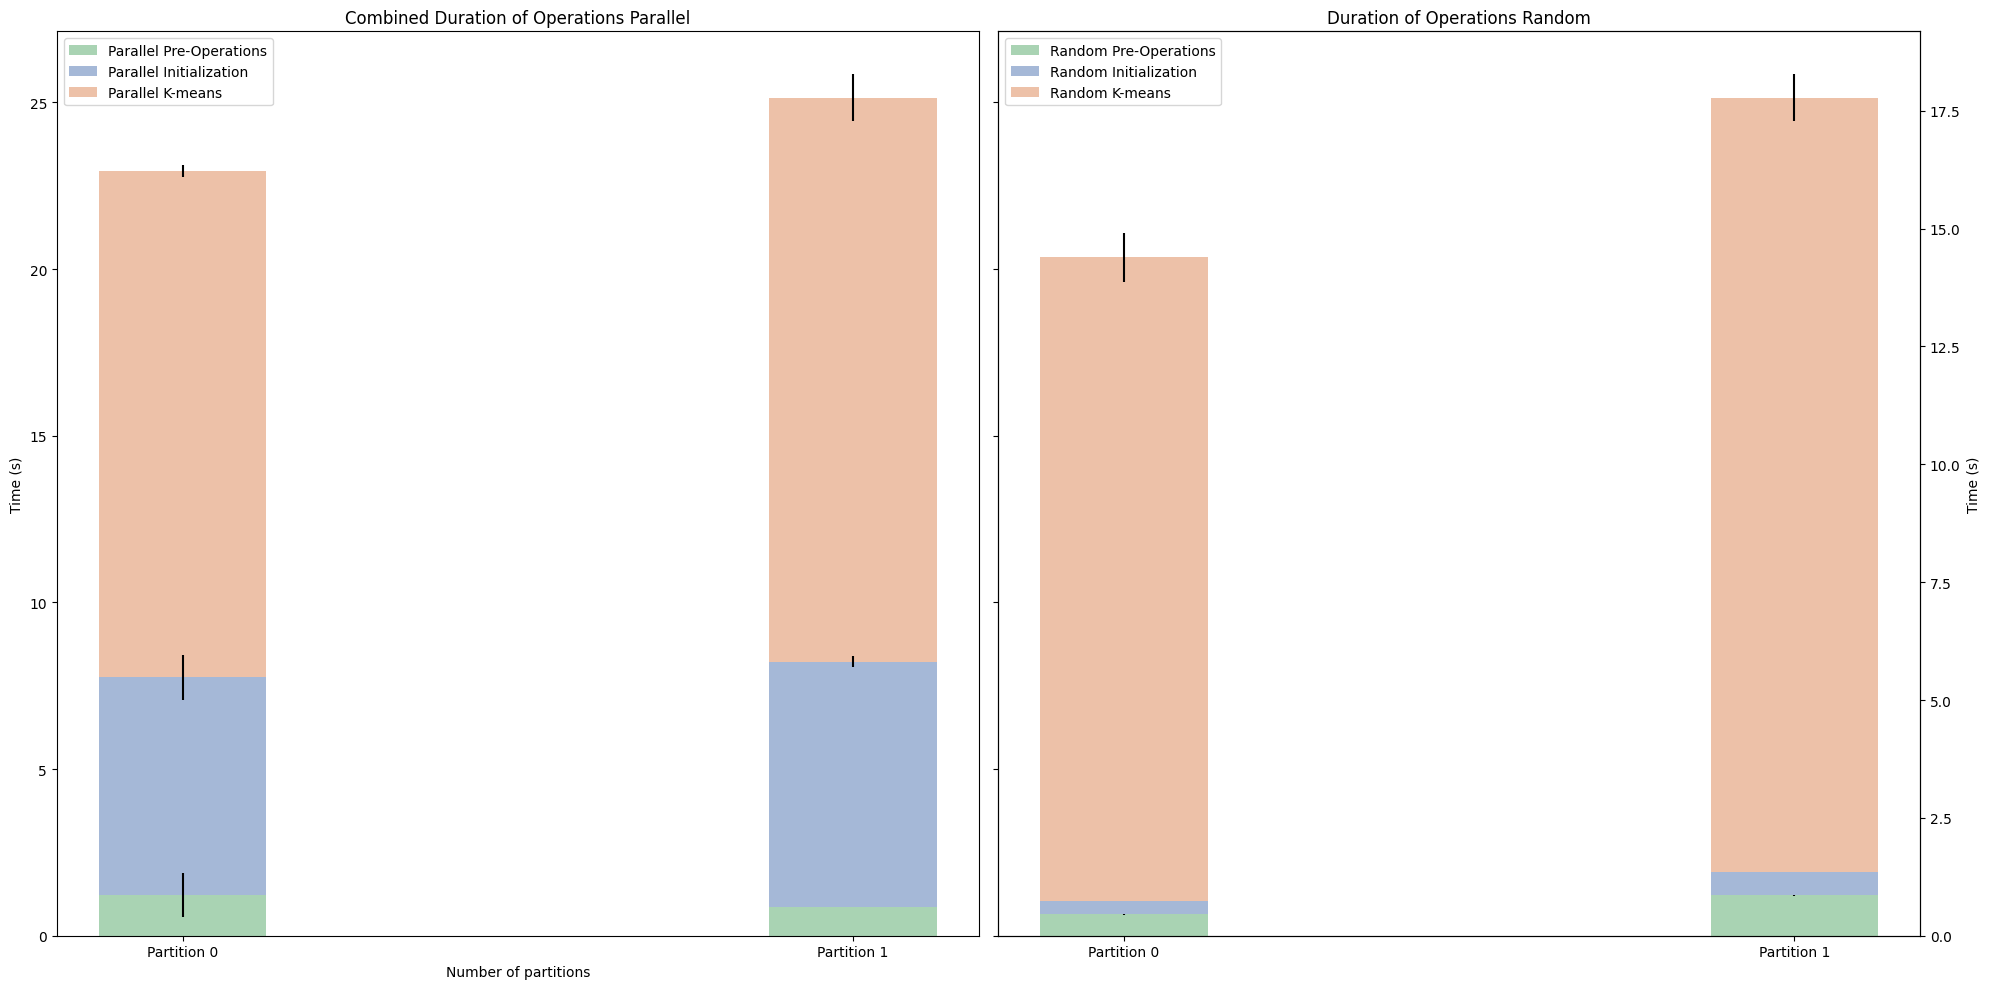

In [38]:
# Creazione del plot principale
fig, axs = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

barWidth = 0.25  # Larghezza delle barre

# Funzione per creare il subplot principale
def create_subplot(ax, indices, mean1, mean2, mean3, std1, std2, std3, title, label1, label2, label3, color1, color2, color3):
    ax.bar(indices, mean1, barWidth, yerr=std1, label=label1, color=color1, alpha=0.5)
    ax.bar(indices, mean2, barWidth, yerr=std2, label=label2, color=color2, alpha=0.5, bottom=mean1)
    ax.bar(indices, mean3, barWidth, yerr=std3, label=label3, color=color3, alpha=0.5, bottom=mean1+mean2)
    ax.set_title(title)
    ax.set_xlabel("Number of partitions")
    ax.set_ylabel("Time (s)")
    ax.legend()
    ax.set_xticks(indices)
    ax.set_xticklabels([f"Partition {i}" for i in range(len(indices))])

# Applicazione della funzione al subplot principale (a sinistra)
create_subplot(axs[0], indices, meanPpre, meanPinit, meanPkmeans,  stdPpre, stdPinit, stdPkmeans,
               "Combined Duration of Operations Parallel", "Parallel Pre-Operations", "Parallel Initialization", "Parallel K-means",
               colorPre, colorInit, colorKmeans)

# Creazione del subplot a destra
ax_right = axs[1].twinx()  # Creazione di un nuovo asse y a destra

# Applicazione della funzione al subplot a destra
create_subplot(ax_right, indices, meanRpre, meanRinit, meanRkmeans, stdRpre, stdRinit, stdRkmeans,
               "Duration of Operations Random", "Random Pre-Operations", "Random Initialization", "Random K-means",
               colorPre, colorInit, colorKmeans)

plt.tight_layout()
plt.show()